In [65]:
from __future__ import annotations

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio import plot

from landnet.config import FIGURES_DIR, GRIDS
from landnet.dataset import get_dem_tiles
from landnet.features.tiles import Grid, TileConfig, TileSize

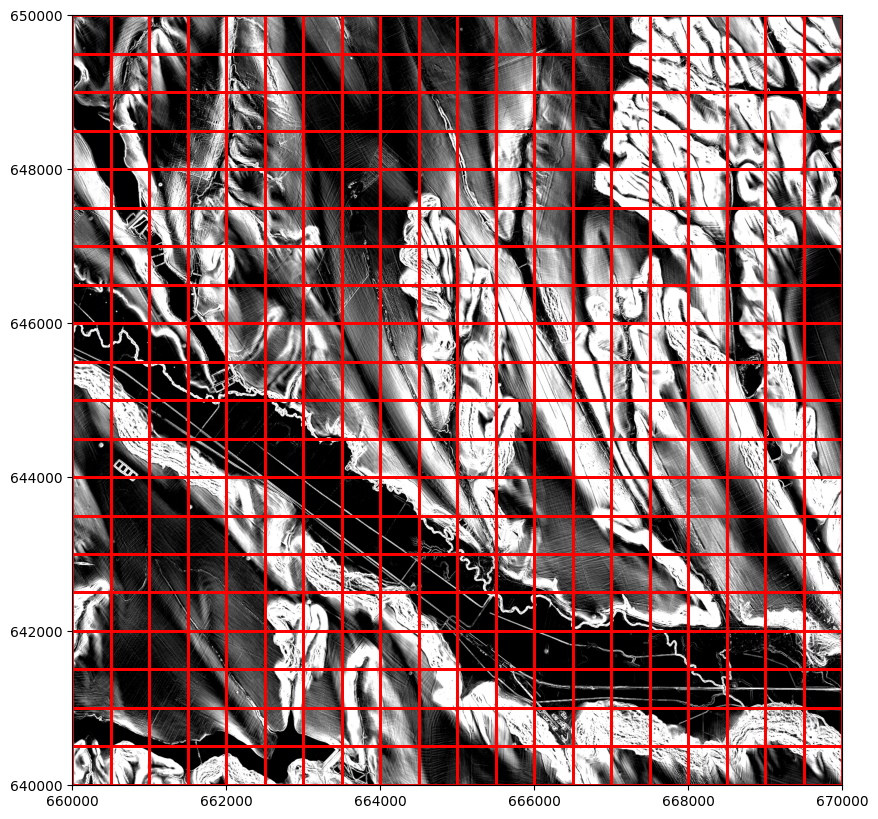

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
# Load raster data
with rasterio.open(GRIDS / 'train' / 'shade.tif', nodata=-99999.0) as src:
    raster_data = src.read(1)  # Read the first band
    # Remove rows where all values are 0a
    # raster_data = raster_data[~np.any(raster_data == -32767.0, axis=1)]
    # raster_data = raster_data[~np.any(raster_data == -99999., axis=1)]

    # Remove columns where all values are 0
    # raster_data = raster_data[:, ~np.any(raster_data == -32767.0, axis=0)]
    # raster_data = raster_data[:, ~np.any(raster_data == -99999.0, axis=0)]

    raster_extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top,
    ]
    transform = src.transform

# Load polygon data
gdf = get_dem_tiles()
gdf = gdf[gdf['mode'] == 'train']


# Ensure CRS match
gdf = gdf.to_crs(src.crs)
# Plot raster and polygons
# ax.imshow(raster_data, extent=raster_extent, cmap='gray')
plot.show(
    raster_data,
    transform=transform,
    ax=ax,
    cmap='gray',
    vmin=np.percentile(raster_data, 20),
    vmax=np.percentile(raster_data, 80),
)

# Plot polygons
gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=2, facecolor='none')

plt.xlim(raster_extent[0], raster_extent[1])
plt.ylim(raster_extent[2], raster_extent[3])
plt.show()

In [28]:
grid = Grid(
    GRIDS / 'train' / 'shade.tif',
    tile_config=TileConfig(TileSize(100, 100), 50),
)
tile_length = grid.get_tiles_length()

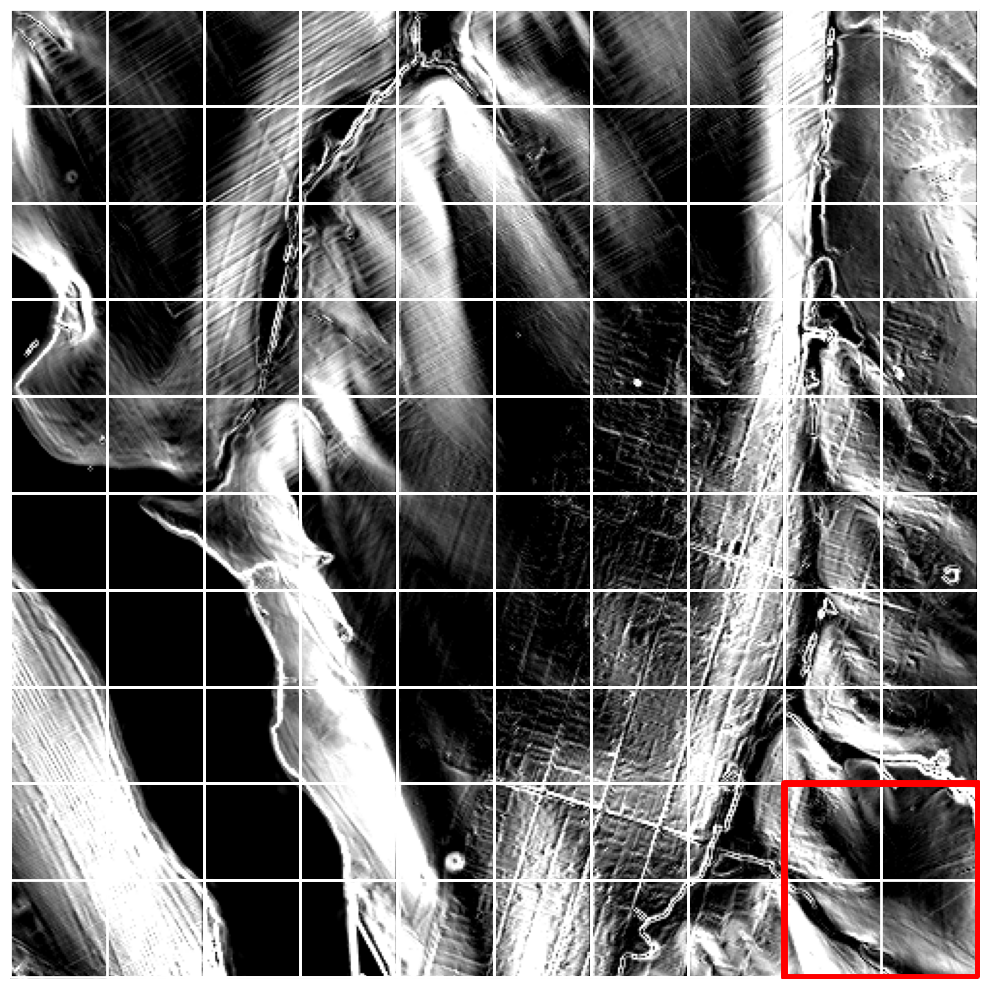

In [69]:
from IPython.display import clear_output
from shapely import box

out_dir = FIGURES_DIR / 'overlap_gif'
out_dir.mkdir(exist_ok=True)
running_bounds = []
raster_bounds = [
    raster_extent[0],
    raster_extent[1] - 7500,
    raster_extent[2] + 7500,
    raster_extent[3],
]
raster_box = box(
    raster_bounds[0], raster_bounds[2], raster_bounds[1], raster_bounds[3]
)
import time

for i in range(tile_length):
    *_, bounds = grid.get_tile_bounds(i)
    if not bounds.within(raster_box):
        continue
    fig, ax = plt.subplots(figsize=(10, 10))

    plot.show(
        raster_data,
        transform=transform,
        ax=ax,
        cmap='gray',
        vmin=np.percentile(raster_data, 20),
        vmax=np.percentile(raster_data, 80),
    )

    current_bound_gs = gpd.GeoSeries([bounds])
    running_bounds_gs = gpd.GeoSeries(running_bounds)

    running_bounds_gs.plot(
        ax=ax, color='none', edgecolor='white', linewidth=2, facecolor='none'
    )
    current_bound_gs.plot(
        ax=ax, color='none', edgecolor='red', linewidth=5, facecolor='none'
    )

    ax.set_xlim(raster_bounds[0], raster_bounds[1])
    ax.set_ylim(raster_bounds[2], raster_bounds[3], auto=True)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(out_dir / f'{i}.png', dpi=300)
    plt.show()

    time.sleep(0.1)
    clear_output(wait=True)
    running_bounds.append(bounds)
    # break